### Binary classification about diagnosing AIDS.

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from bpitnorm.modules.BatchPitNormalization import BatchPitNorm1d

device = "cuda" if torch.cuda.is_available() else "cpu"

data = np.genfromtxt("Data/AIDS_Classification.csv", delimiter=",", skip_header=1)
data = data[~(np.isnan(data)).any(axis=1)]
data = data[~(np.isinf(data)).any(axis=1)]
print("Number of features: ", data.shape[1])
print("Number of datapoints: ", data.shape[0])

def data_split(data):
  X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data[:, :-1], data[:, -1], test_size=0.2)
  y_train_raw = y_train_raw.reshape(-1, 1)
  y_test_raw = y_test_raw.reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler_x = scaler1.fit(X_train_raw)
  X_train = scaler_x.transform(X_train_raw)
  X_test = scaler_x.transform(X_test_raw)

  scaler2 = StandardScaler()
  scaler_y = scaler2.fit(y_train_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
  y_test = torch.tensor(y_test_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  return X_train, y_train, X_test, y_test, scaler_y

Number of features:  23
Number of datapoints:  2139


In [5]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, loops):
    model.to(device=device)
    acc_lst = np.zeros(loops)
    f1_lst = np.zeros(loops)

    for i in range(loops):
        X_train, y_train, X_test, y_test, scaler_y = data_split(data)
        loss_fn = nn.BCEWithLogitsLoss().to(device=device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=150, shuffle=True)
        n_epochs = 30
        for epoch in range(n_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward(retain_graph=True)
                optimizer.step()
                optimizer.zero_grad()
        model.eval()
        y_pred = model(X_test)
        y_pred_prob = torch.sigmoid(y_pred)
        y_pred_binary = (y_pred_prob > 0.5).float().cpu().detach()
        acc = accuracy_score(y_test.cpu(), y_pred_binary)
        acc_lst[i] = float(acc)
        f1 = f1_score(y_test.cpu(), y_pred_binary)
        f1_lst[i] = float(f1)
        print("Accuracy:", float(acc))
        print("F1-score:", float(f1))
    return acc_lst, f1_lst

Accuracy: 0.897196261682243
F1-score: 0.7755102040816326
Accuracy: 0.9088785046728972
F1-score: 0.821917808219178
Accuracy: 0.9345794392523364
F1-score: 0.86
Accuracy: 0.9509345794392523
F1-score: 0.8975609756097561
Accuracy: 0.9626168224299065
F1-score: 0.9139784946236559


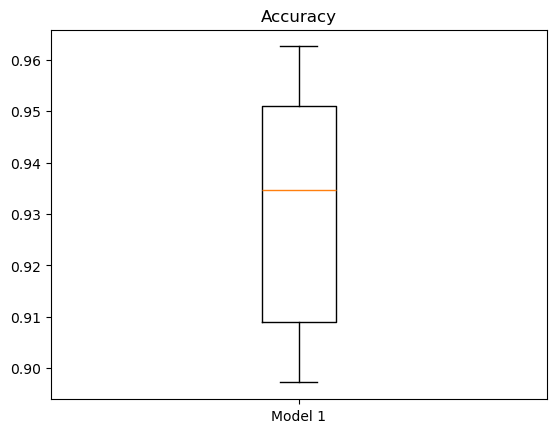

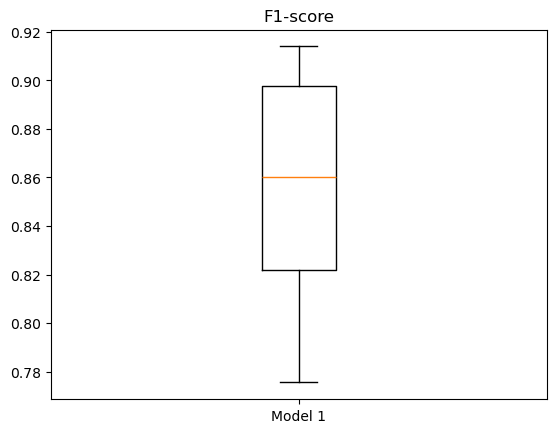

In [8]:
model1 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))

acc1, f1_1 = train_model(model1, 5)
plt.boxplot(acc1, labels=["Model 1"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_1, labels=["Model 1"])
plt.title("F1-score")
plt.show()

Accuracy: 0.8644859813084113
F1-score: 0.7156862745098039
Accuracy: 0.9392523364485982
F1-score: 0.8673469387755102
Accuracy: 0.9649532710280374
F1-score: 0.926829268292683
Accuracy: 0.9579439252336449
F1-score: 0.9181818181818182
Accuracy: 0.9742990654205608
F1-score: 0.9417989417989417


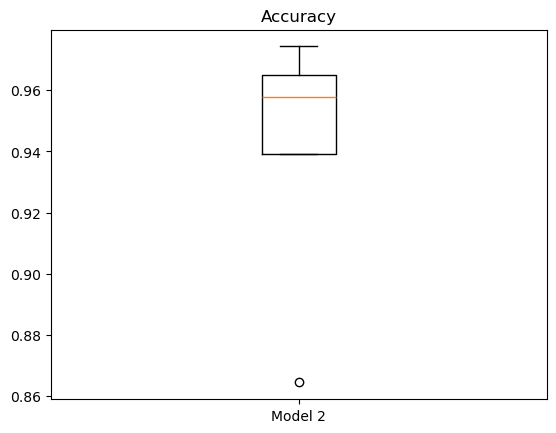

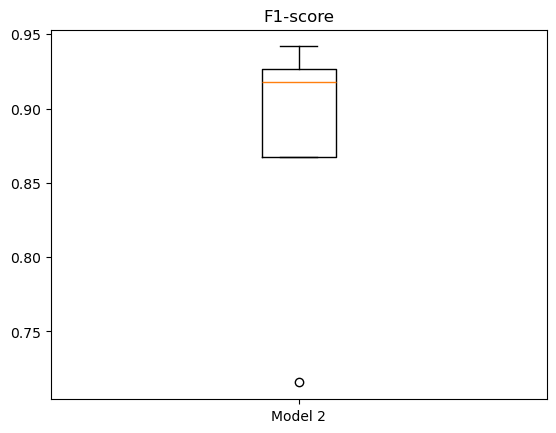

In [13]:
model2 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))

model2.to(device=device)

acc2, f1_2 = train_model(model2, 5)
plt.boxplot(acc2, labels=["Model 2"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_2, labels=["Model 2"])
plt.title("F1-score")
plt.show()

Accuracy: 0.9135514018691588
F1-score: 0.8121827411167513
Accuracy: 0.8948598130841121
F1-score: 0.7738693467336684
Accuracy: 0.9392523364485982
F1-score: 0.8712871287128713
Accuracy: 0.9228971962616822
F1-score: 0.8374384236453202
Accuracy: 0.9392523364485982
F1-score: 0.8631578947368421


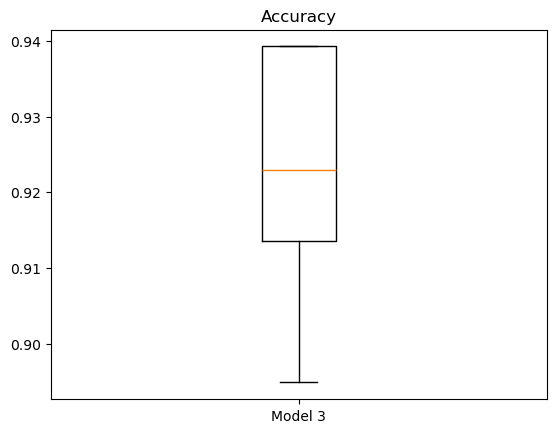

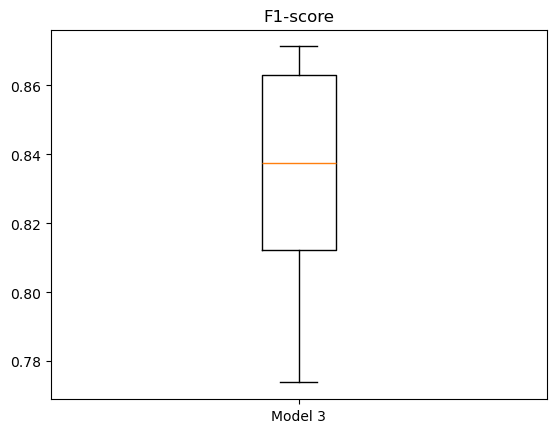

In [16]:
model3 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    BatchPitNorm1d(num_features=100, num_pit_samples=100, take_num_samples_when_full=50, dev=device),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model3.to(device=device)

acc3, f1_3 = train_model(model3, 5)
plt.boxplot(acc3, labels=["Model 3"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_3, labels=["Model 3"])
plt.title("F1-score")
plt.show()

Accuracy: 0.8785046728971962
F1-score: 0.717391304347826
Accuracy: 0.8878504672897196
F1-score: 0.7419354838709677
Accuracy: 0.9135514018691588
F1-score: 0.821256038647343
Accuracy: 0.9345794392523364
F1-score: 0.86
Accuracy: 0.9579439252336449
F1-score: 0.91


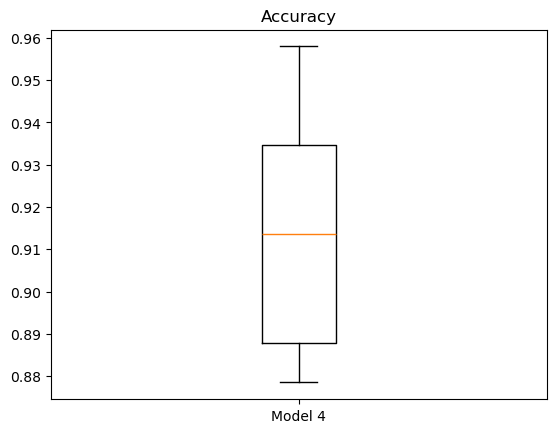

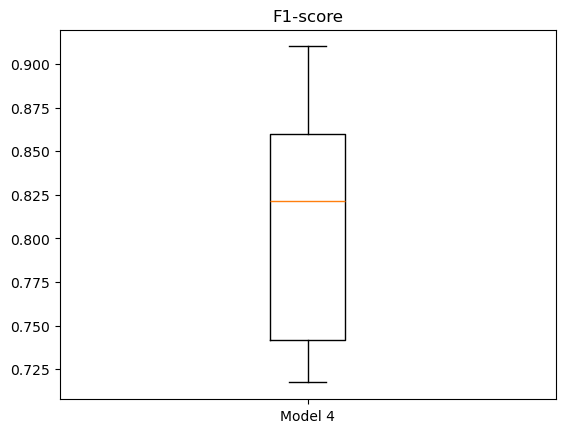

In [19]:
model4 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    BatchPitNorm1d(num_features=100, num_pit_samples=100, take_num_samples_when_full=50, dev=device),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model4.to(device=device)

acc4, f1_4 = train_model(model4, 5)
plt.boxplot(acc4, labels=["Model 4"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_4, labels=["Model 4"])
plt.title("F1-score")
plt.show()

Accuracy: 0.8855140186915887
F1-score: 0.7487179487179487
Accuracy: 0.9018691588785047
F1-score: 0.79
Accuracy: 0.9088785046728972
F1-score: 0.8115942028985508
Accuracy: 0.9018691588785047
F1-score: 0.8205128205128205
Accuracy: 0.9345794392523364
F1-score: 0.8613861386138614


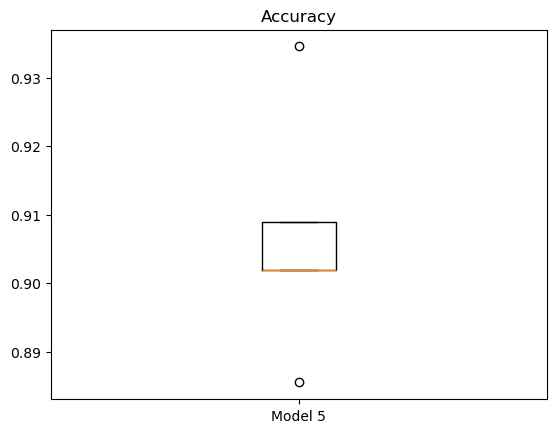

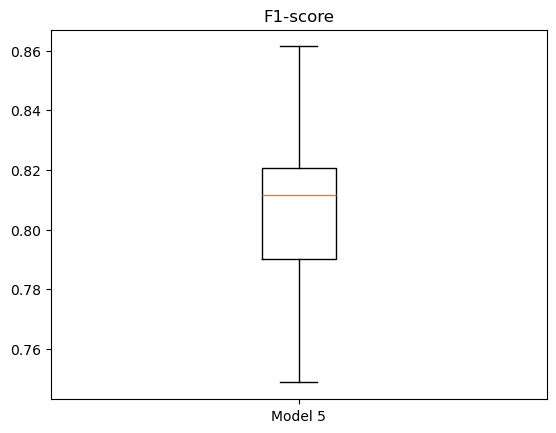

In [22]:
model5 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 150),
    nn.ReLU(),
    nn.Linear(150, 30),
    BatchPitNorm1d(num_features=30, num_pit_samples=100, take_num_samples_when_full=50, dev=device),
    nn.ReLU(),
    nn.Linear(30, 80),
    nn.ReLU(),
    nn.Linear(80, 1))
model5.to(device=device)

acc5, f1_5 = train_model(model5, 5)
plt.boxplot(acc5, labels=["Model 5"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_5, labels=["Model 5"])
plt.title("F1-score")
plt.show()

Accuracy: 0.8177570093457944
F1-score: 0.6694915254237288
Accuracy: 0.8387850467289719
F1-score: 0.684931506849315
Accuracy: 0.8154205607476636
F1-score: 0.6775510204081633
Accuracy: 0.8247663551401869
F1-score: 0.6696035242290749
Accuracy: 0.8551401869158879
F1-score: 0.69


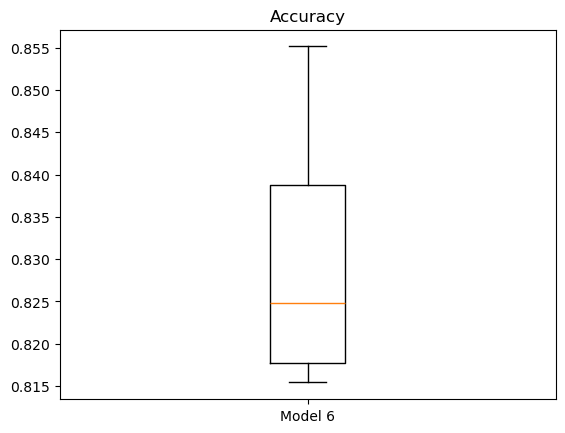

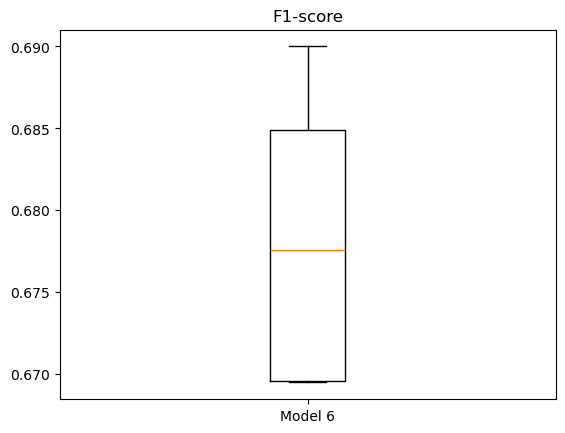

In [25]:
model6 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=100, take_num_samples_when_full=50, dev=device),
    nn.ReLU(),
    nn.Linear(10, 1))
model6.to(device=device)

acc6, f1_6 = train_model(model6, 5)
plt.boxplot(acc6, labels=["Model 6"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_6, labels=["Model 6"])
plt.title("F1-score")
plt.show()

In [29]:
from itertools import product


param_grid = {
  'num_pit_samples': [50, 100, 150, 250, 500, 1000],
  'take_num_samples_when_full': [0, 1, 2, 3, 5, 10, 20],
  'normal_backtransform': [True, False],
  'trainable_bandwidths': [True, False]
}

best_acc_g = -np.inf
best_params = None

for params in product(*param_grid.values()):
  num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
  print(f"num_pit_samples={num_pit_samples}, take_num_samples_when_full={take_num_samples_when_full},"+
        f" normal_backtransform={normal_backtransform}, trainable_bandwidths={trainable_bandwidths}")

  model_g = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    BatchPitNorm1d(num_features=100, num_pit_samples=num_pit_samples, take_num_samples_when_full=take_num_samples_when_full,
                    normal_backtransform=normal_backtransform, trainable_bandwidths=trainable_bandwidths, dev=device),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
  )
  
  acc_g, f1_g = train_model(model_g, 5)
  
  if np.mean(acc_g) > np.mean(best_acc_g):
    best_acc_g = acc_g
    best_f1_g = f1_g
    best_params = params

plt.boxplot(best_acc_g, labels=["Grid search"])
plt.title(params)
plt.show()

plt.boxplot(best_f1_g, labels=["Grid search"])
plt.title(params)
plt.show()

print(f"Best params: {best_params} with accuracy: {np.mean(best_acc_g)}, F1-score: {np.mean(best_f1_g)}")


num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=True
Accuracy: 0.8808411214953271
F1-score: 0.7329842931937173
Accuracy: 0.8948598130841121
F1-score: 0.7926267281105991
Accuracy: 0.9182242990654206
F1-score: 0.8341232227488151
Accuracy: 0.9532710280373832
F1-score: 0.9065420560747663
Accuracy: 0.969626168224299
F1-score: 0.9406392694063926
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=False
Accuracy: 0.8644859813084113
F1-score: 0.7156862745098039
Accuracy: 0.9135514018691588
F1-score: 0.8102564102564103
Accuracy: 0.9322429906542056
F1-score: 0.8527918781725888
Accuracy: 0.9602803738317757
F1-score: 0.9178743961352657
Accuracy: 0.985981308411215
F1-score: 0.9647058823529412
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=True
Accuracy: 0.9252336448598131
F1-score: 0.8315789473684211
Accuracy: 0.8948598130841121
F1-score: 0.784688995215

KeyboardInterrupt: 

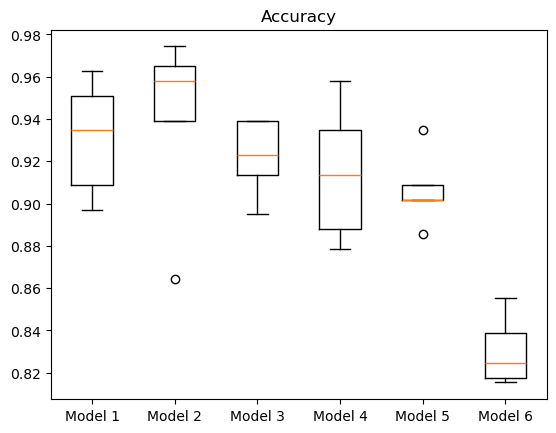

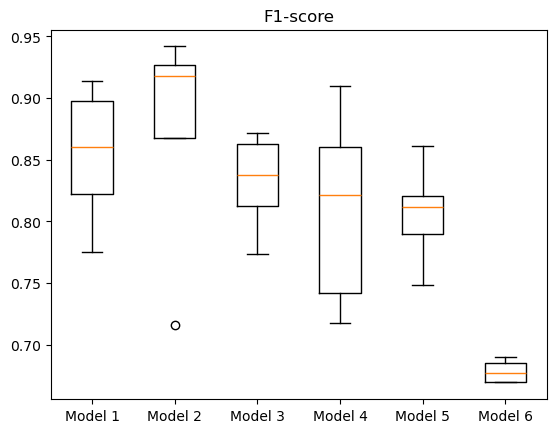

In [27]:
plt.boxplot([acc1, acc2, acc3, acc4, acc5, acc6, best_acc_g], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", "Grid Search"])
plt.title("Accuracy")
plt.show()

plt.boxplot([f1_1, f1_2, f1_3, f1_4, f1_5, f1_6, best_f1_g], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", "Grid search"])
plt.title("F1-score")
plt.show()

Model 1: Without any batch normalization layer.

Model 2: With one ordinary batch normalization layer.

Model 3: With one batch pit normalization layer.

Model 4: With one batch pit normalization layer and one ordinary batch norm layer.

Model 5: With one batch pit normalization layer.

Model 6: With one batch pit normalization layer and one ordinary batch norm layer.


From these three models, the first model (the one without any batch normalization layer) seems to be the best. It seems to be around $92\%$ which is pretty accurate